# Decoder LLM with KV Cache: Prefill and Decode Demonstration

This notebook demonstrates:
1. How a simple decoder LLM works
2. The prefill phase (processing initial prompt tokens)
3. The decode phase (generating new tokens)
4. How KV cache accelerates the decode phase

We'll use a simplified implementation to show the core concepts clearly.


## Imports and Setup


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Optional, Tuple, Dict
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


## Simple Decoder LLM Implementation

We'll create a minimal decoder-only transformer to demonstrate the concepts. In practice, you'd use libraries like `transformers` or `vllm`, but this helps illustrate how KV cache works.


In [2]:
@dataclass
class KVCache:
    """Simple KV cache storage"""
    keys: torch.Tensor  # Shape: [batch_size, seq_len, num_heads, head_dim]
    values: torch.Tensor  # Shape: [batch_size, seq_len, num_heads, head_dim]
    
    def append(self, new_keys: torch.Tensor, new_values: torch.Tensor):
        """Append new KV pairs to the cache"""
        self.keys = torch.cat([self.keys, new_keys], dim=1)
        self.values = torch.cat([self.values, new_values], dim=1)
    
    def get_cache_size(self):
        """Return the current sequence length in cache"""
        return self.keys.shape[1]


In [3]:
class SimpleAttention(nn.Module):
    """Simplified self-attention layer with KV cache support"""
    
    def __init__(self, hidden_size: int, num_heads: int = 4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        
        # Q, K, V projection matrices
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)
        self.o_proj = nn.Linear(hidden_size, hidden_size)
        
    def forward(
        self,
        x: torch.Tensor,
        kv_cache: Optional[KVCache] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Input tensor [batch_size, seq_len, hidden_size]
            kv_cache: Optional KV cache from previous computations
        
        Returns:
            output: Attention output [batch_size, seq_len, hidden_size]
            all_keys: Keys for the full context [batch_size, total_seq_len, num_heads, head_dim]
            all_values: Values for the full context [batch_size, total_seq_len, num_heads, head_dim]
        """
        batch_size, seq_len, _ = x.shape
        
        # Compute Q, K, V
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        if kv_cache is not None:
            cached_k = kv_cache.keys.transpose(1, 2)  # [batch, heads, cached_seq, head_dim]
            cached_v = kv_cache.values.transpose(1, 2)
            k_full = torch.cat([cached_k, k], dim=2)
            v_full = torch.cat([cached_v, v], dim=2)
        else:
            k_full = k
            v_full = v
        
        # Compute attention scores using the full context
        scores = torch.matmul(q, k_full.transpose(-2, -1)) / np.sqrt(self.head_dim)
        
        # Apply causal mask (only attend to previous tokens)
        if kv_cache is None:
            mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(scores.device)
            scores = scores.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('-inf'))
        
        # Softmax
        attn_weights = F.softmax(scores, dim=-1)
        
        # Apply attention to values from the full context
        output = torch.matmul(attn_weights, v_full)  # [batch, heads, seq_len, head_dim]
        
        # Reshape and project
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.hidden_size)
        output = self.o_proj(output)
        
        all_keys = k_full.transpose(1, 2)   # [batch, total_seq_len, num_heads, head_dim]
        all_values = v_full.transpose(1, 2)
        
        return output, all_keys, all_values


In [4]:
class DecoderBlock(nn.Module):
    """Single decoder block with attention and feed-forward"""
    
    def __init__(self, hidden_size: int, num_heads: int = 4):
        super().__init__()
        self.attention = SimpleAttention(hidden_size, num_heads)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        
        # Simple feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
    
    def forward(
        self,
        x: torch.Tensor,
        kv_cache: Optional[KVCache] = None
    ) -> Tuple[torch.Tensor, KVCache]:
        """
        Args:
            x: Input tensor [batch_size, seq_len, hidden_size]
            kv_cache: Optional KV cache
        
        Returns:
            output: Block output
            updated_cache: Updated KV cache for this layer
        """
        residual = x
        attn_out, all_keys, all_values = self.attention(self.norm1(x), kv_cache)
        x = residual + attn_out
        
        residual = x
        ffn_out = self.ffn(self.norm2(x))
        x = residual + ffn_out
        
        if kv_cache is None:
            updated_cache = KVCache(keys=all_keys, values=all_values)
        else:
            cached_len = kv_cache.get_cache_size()
            new_keys = all_keys[:, cached_len:, :, :]
            new_values = all_values[:, cached_len:, :, :]
            if new_keys.shape[1] > 0:
                kv_cache.append(new_keys, new_values)
            updated_cache = kv_cache
        
        return x, updated_cache


In [5]:
class SimpleDecoderLLM(nn.Module):
    """Simple decoder-only language model"""
    
    def __init__(
        self,
        vocab_size: int = 1000,
        hidden_size: int = 128,
        num_layers: int = 2,
        num_heads: int = 4
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Token embeddings
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        
        # Decoder blocks
        self.blocks = nn.ModuleList([
            DecoderBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])
        
        # Output projection
        self.lm_head = nn.Linear(hidden_size, vocab_size)
    
    def forward(
        self,
        token_ids: torch.Tensor,
        kv_caches: Optional[Dict[int, KVCache]] = None
    ) -> Tuple[torch.Tensor, Dict[int, KVCache]]:
        """
        Args:
            token_ids: Input token IDs [batch_size, seq_len]
            kv_caches: Optional dict of KV caches per layer
        
        Returns:
            logits: Output logits [batch_size, seq_len, vocab_size]
            new_kv_caches: Updated KV caches
        """
        # Get embeddings
        x = self.embedding(token_ids)
        
        # Process through decoder blocks
        new_kv_caches = {}
        for layer_idx, block in enumerate(self.blocks):
            kv_cache = kv_caches.get(layer_idx) if kv_caches else None
            x, updated_cache = block(x, kv_cache)
            new_kv_caches[layer_idx] = updated_cache
        
        # Project to vocabulary
        logits = self.lm_head(x)
        
        return logits, new_kv_caches


## Prefill Phase Demonstration

The prefill phase processes the initial prompt tokens. All tokens are processed in parallel, and we compute the KV cache for all positions.


In [6]:
# Create a simple model
model = SimpleDecoderLLM(
    vocab_size=1000,
    hidden_size=128,
    num_layers=2,
    num_heads=4
)
model.eval()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def clone_kv_caches(kv_dict: Dict[int, KVCache]) -> Dict[int, KVCache]:
    """Deep copy the KV caches so we can reuse the same prefill state."""
    return {
        layer_idx: KVCache(keys=cache.keys.clone(), values=cache.values.clone())
        for layer_idx, cache in kv_dict.items()
    }

print(f"Model created: {count_parameters(model):,} parameters")
print(f"Hidden size: {model.hidden_size}, Layers: {model.num_layers}")


Model created: 653,544 parameters
Hidden size: 128, Layers: 2


In [7]:
# Simulate a prompt: "Hello, my name is"
# In practice, you'd tokenize this with a real tokenizer
prompt_tokens = torch.tensor([[10, 20, 30, 40, 50]])  # 5 tokens
batch_size, prompt_len = prompt_tokens.shape

print(f"Prefill Phase: Processing {prompt_len} prompt tokens")
print(f"Token IDs: {prompt_tokens.tolist()[0]}")
print("\nProcessing all tokens in parallel...")

# Prefill: no KV cache initially
with torch.no_grad():
    logits, kv_caches = model(prompt_tokens, kv_caches=None)

print(f"\nPrefill complete!")
print(f"Output logits shape: {logits.shape}")  # [batch, seq_len, vocab_size]
print(f"KV cache created for {len(kv_caches)} layers")
print(f"Each KV cache has sequence length: {kv_caches[0].get_cache_size()}")

# Show the cache structure
for layer_idx, cache in kv_caches.items():
    print(f"\nLayer {layer_idx} KV Cache:")
    print(f"  Keys shape: {cache.keys.shape}")
    print(f"  Values shape: {cache.values.shape}")


Prefill Phase: Processing 5 prompt tokens
Token IDs: [10, 20, 30, 40, 50]

Processing all tokens in parallel...

Prefill complete!
Output logits shape: torch.Size([1, 5, 1000])
KV cache created for 2 layers
Each KV cache has sequence length: 5

Layer 0 KV Cache:
  Keys shape: torch.Size([1, 5, 4, 32])
  Values shape: torch.Size([1, 5, 4, 32])

Layer 1 KV Cache:
  Keys shape: torch.Size([1, 5, 4, 32])
  Values shape: torch.Size([1, 5, 4, 32])


## Decode Phase Demonstration

The decode phase generates new tokens one at a time. We reuse the KV cache from prefill, so we only need to:
1. Process the new token
2. Append its KV cache to the existing cache

This is much faster than recomputing attention over all previous tokens!


In [8]:
def sample_token(logits: torch.Tensor) -> int:
    """Simple greedy sampling (take highest probability token)"""
    last_token_logits = logits[0, -1, :]
    token_id = torch.argmax(last_token_logits).item()
    return token_id

print("Decode Phase: Generating tokens one at a time using KV cache")
print("=" * 60)

# Work on a clone so we keep the prefill caches intact
current_kv_caches = clone_kv_caches(kv_caches)
generated_tokens: list[int] = []
num_tokens_to_generate = 5

if num_tokens_to_generate <= 0:
    print("No tokens requested; skipping decode phase.")
else:
    device = prompt_tokens.device
    first_token = sample_token(logits)
    generated_tokens.append(first_token)
    print(f"Token 1 (from prefill logits): {first_token}")
    current_token = torch.tensor([[first_token]], dtype=torch.long, device=device)
    
    for step in range(1, num_tokens_to_generate):
        print(f"\n--- Decode Step {step} ---")
        print(f"Input token ID: {current_token.item()}")
        print(f"KV cache size before decode: {current_kv_caches[0].get_cache_size()}")
        
        with torch.no_grad():
            step_logits, current_kv_caches = model(current_token, kv_caches=current_kv_caches)
        
        next_token = sample_token(step_logits)
        generated_tokens.append(next_token)
        
        print(f"Generated token ID: {next_token}")
        print(f"KV cache size after decode: {current_kv_caches[0].get_cache_size()}")
        print(f"\nKey insight: We only processed 1 token, but attention can see all {current_kv_caches[0].get_cache_size()} tokens!")
        
        current_token = torch.tensor([[next_token]], dtype=torch.long, device=device)


Decode Phase: Generating tokens one at a time using KV cache
Token 1 (from prefill logits): 988

--- Decode Step 1 ---
Input token ID: 988
KV cache size before decode: 5
Generated token ID: 254
KV cache size after decode: 6

Key insight: We only processed 1 token, but attention can see all 6 tokens!

--- Decode Step 2 ---
Input token ID: 254
KV cache size before decode: 6
Generated token ID: 767
KV cache size after decode: 7

Key insight: We only processed 1 token, but attention can see all 7 tokens!

--- Decode Step 3 ---
Input token ID: 767
KV cache size before decode: 7
Generated token ID: 487
KV cache size after decode: 8

Key insight: We only processed 1 token, but attention can see all 8 tokens!

--- Decode Step 4 ---
Input token ID: 487
KV cache size before decode: 8
Generated token ID: 930
KV cache size after decode: 9

Key insight: We only processed 1 token, but attention can see all 9 tokens!


In [9]:
print("\n" + "=" * 60)
print("Summary of Prefill + Decode")
print("=" * 60)
print(f"\nPrompt tokens: {prompt_tokens.tolist()[0]}")
print(f"Generated tokens (sampled): {generated_tokens}")

total_seq_len = current_kv_caches[0].get_cache_size()
cached_generated = total_seq_len - prompt_len
print(f"\nTotal sequence length in KV cache: {total_seq_len}")
print(f"  - Prompt: {prompt_len} tokens")
print(f"  - Generated cached: {cached_generated} tokens")
print(f"  - Generated sampled (including next-to-process): {len(generated_tokens)} tokens")
print(f"\n✅ KV cache successfully accumulated the processed tokens!")



Summary of Prefill + Decode

Prompt tokens: [10, 20, 30, 40, 50]
Generated tokens (sampled): [988, 254, 767, 487, 930]

Total sequence length in KV cache: 9
  - Prompt: 5 tokens
  - Generated cached: 4 tokens
  - Generated sampled (including next-to-process): 5 tokens

✅ KV cache successfully accumulated the processed tokens!


## Performance Comparison: With vs Without KV Cache

Let's demonstrate why KV cache is essential for efficient decoding.


In [10]:
import time

def decode_without_kv_cache(model, prompt_tokens, num_tokens):
    """Decode without KV cache (inefficient - recomputes everything)"""
    generated = []
    current_sequence = prompt_tokens.clone()
    device = prompt_tokens.device
    
    for _ in range(num_tokens):
        with torch.no_grad():
            logits, _ = model(current_sequence, kv_caches=None)
        next_token = sample_token(logits)
        generated.append(next_token)
        next_token_tensor = torch.tensor([[next_token]], dtype=torch.long, device=device)
        current_sequence = torch.cat([current_sequence, next_token_tensor], dim=1)
    
    return generated

def decode_with_kv_cache(model, prompt_tokens, kv_caches, prefill_logits, num_tokens):
    """Decode with KV cache (efficient)"""
    generated = []
    if num_tokens <= 0:
        return generated
    
    current_kv_caches = clone_kv_caches(kv_caches)
    device = prompt_tokens.device
    
    first_token = sample_token(prefill_logits)
    generated.append(first_token)
    current_token = torch.tensor([[first_token]], dtype=torch.long, device=device)
    
    for _ in range(num_tokens - 1):
        with torch.no_grad():
            logits, current_kv_caches = model(current_token, kv_caches=current_kv_caches)
        next_token = sample_token(logits)
        generated.append(next_token)
        current_token = torch.tensor([[next_token]], dtype=torch.long, device=device)
    
    return generated

# Compare performance
num_decode_tokens = 10

print(f"Comparing decode performance for {num_decode_tokens} tokens...")
print("=" * 60)

# With KV cache
start_time = time.time()
generated_with_cache = decode_with_kv_cache(model, prompt_tokens, kv_caches, logits, num_decode_tokens)
time_with_cache = time.time() - start_time

# Without KV cache (recompute everything)
start_time = time.time()
generated_without_cache = decode_without_kv_cache(model, prompt_tokens, num_decode_tokens)
time_without_cache = time.time() - start_time

print(f"\nWith KV Cache:    {time_with_cache:.4f} seconds")
print(f"Without KV Cache: {time_without_cache:.4f} seconds")
print(f"\nSpeedup: {time_without_cache / time_with_cache:.2f}x faster with KV cache!")
print(f"\nGenerated tokens (with cache): {generated_with_cache}")
print(f"Generated tokens (without cache): {generated_without_cache}")


Comparing decode performance for 10 tokens...

With KV Cache:    0.0055 seconds
Without KV Cache: 0.0090 seconds

Speedup: 1.63x faster with KV cache!

Generated tokens (with cache): [988, 254, 767, 487, 930, 89, 698, 683, 711, 581]
Generated tokens (without cache): [988, 254, 767, 487, 930, 89, 698, 683, 711, 581]


## Visualization: How KV Cache Works

Let's visualize the attention patterns to see how KV cache helps.


Prefill Phase Attention Pattern:
All tokens attend to all previous tokens

Decode Phase Attention Pattern:
Each new token attends to all cached tokens


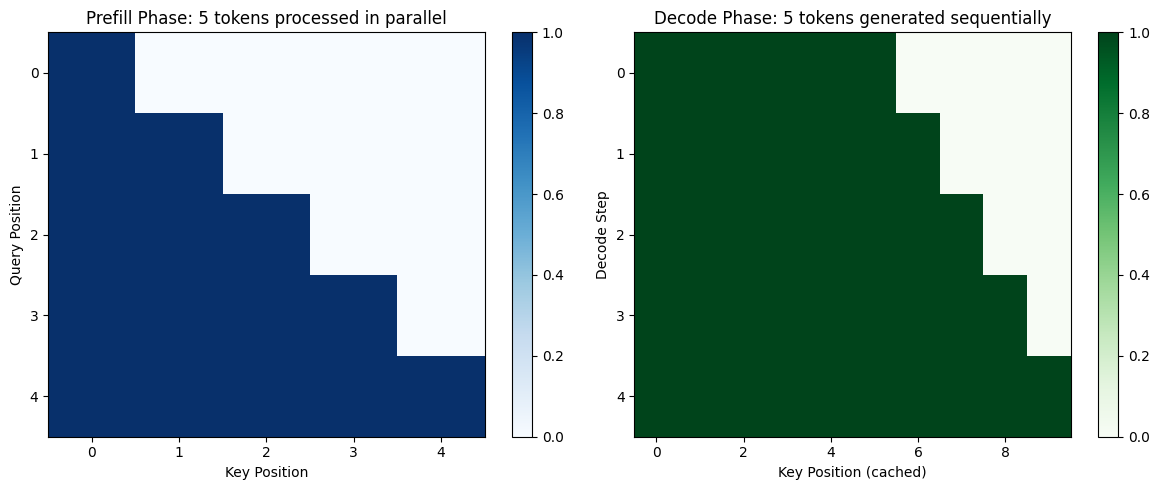


Key insight: In decode phase, each step only processes 1 token,
but can attend to all 10 cached tokens!


In [11]:
def visualize_attention_pattern(model, prompt_tokens, num_decode_steps=3):
    """Visualize attention patterns during prefill and decode"""
    
    # Prefill phase
    print("Prefill Phase Attention Pattern:")
    print("All tokens attend to all previous tokens")
    prefill_len = prompt_tokens.shape[1]
    
    # Create attention matrix for prefill (causal mask)
    prefill_attention = torch.tril(torch.ones(prefill_len, prefill_len))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(prefill_attention.numpy(), cmap='Blues', aspect='auto')
    plt.title(f'Prefill Phase: {prefill_len} tokens processed in parallel')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.colorbar()
    
    # Decode phase
    print("\nDecode Phase Attention Pattern:")
    print("Each new token attends to all cached tokens")
    
    # Simulate decode steps
    decode_attention = []
    current_kv_caches = None
    
    # Get prefill KV cache
    with torch.no_grad():
        _, current_kv_caches = model(prompt_tokens, kv_caches=None)
    
    generated_tokens = []
    current_token = prompt_tokens[:, -1:]
    
    for step in range(num_decode_steps):
        if step > 0:
            current_token = torch.tensor([[generated_tokens[step-1]]])
        
        with torch.no_grad():
            logits, current_kv_caches = model(current_token, kv_caches=current_kv_caches)
        
        # Each decode step: 1 query attends to all cached keys
        cache_size = current_kv_caches[0].get_cache_size()
        attention_row = torch.ones(cache_size)
        decode_attention.append(attention_row.numpy())
        
        # Sample token for next iteration
        if step < num_decode_steps - 1:
            next_token = sample_token(logits)
            generated_tokens.append(next_token)
    
    # Pad for visualization
    max_len = max(len(row) for row in decode_attention)
    decode_matrix = np.array([np.pad(row, (0, max_len - len(row))) for row in decode_attention])
    
    plt.subplot(1, 2, 2)
    plt.imshow(decode_matrix, cmap='Greens', aspect='auto')
    plt.title(f'Decode Phase: {num_decode_steps} tokens generated sequentially')
    plt.xlabel('Key Position (cached)')
    plt.ylabel('Decode Step')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nKey insight: In decode phase, each step only processes 1 token,")
    print(f"but can attend to all {current_kv_caches[0].get_cache_size()} cached tokens!")

visualize_attention_pattern(model, prompt_tokens, num_decode_steps=5)


## Key Concepts Summary

### Prefill Phase:
- Processes all prompt tokens **in parallel**
- Computes KV cache for all prompt positions
- Time complexity: O(n²) for n prompt tokens
- Example: Processing "Hello, my name is" (5 tokens) all at once

### Decode Phase:
- Generates tokens **one at a time**
- Reuses KV cache from prefill + previous decode steps
- Only processes the new token, but can attend to all cached tokens
- Time complexity: O(k) per token where k is cached sequence length
- Example: Generating "Isaac" token by token (4 tokens, one at a time)

### Why KV Cache Matters:
- **Without KV cache**: Each decode step reprocesses all previous tokens → O(n²) per token
- **With KV cache**: Each decode step only processes 1 token → O(n) per token
- This makes decoding **much faster** for long sequences!

### Real-World Usage:
- Libraries like `vLLM` and `transformers` implement KV cache automatically
- The cache can be shared across multiple requests (prefix caching)
- The cache can be transferred between devices (disaggregated inference)
- The cache can be quantized to save memory


## Next Steps

To see KV cache in action with real models:
- Check out `basic_offline_inference.py` for vLLM usage
- Check out `disaggregated_prefill_decode.py` for KV cache transfer
- Check out `prefix_caching.py` for shared KV cache across requests
